#### **Welcome to Assignment 2**
This assignment consists of three parts. Part-1 is based on the content you learned in Week-3 of course and Part-2 is based on the content you learned in Week-4 of the course. Part-3 is **un-graded** and mainly designed to help you flex the Deep Learning muscles grown in Part-2. 

Unlike the first two parts, you'll have to implement everything from scratch in Part-3. If you find answers to questions in Part-3, feel free to head out to the forums and discuss them with your classmates!

#### **Instructions**
1. Use Python 3.x to run this notebook
2. Write your code only in between the lines 'YOUR CODE STARTS HERE' and 'YOUR CODE ENDS HERE'.
you should not change anything else in the code cells, if you do, the answers you are supposed to get at the end of this assignment might be wrong.
3. Read documentation of each function carefully.
4. All the Best!

# Part-1

In [1]:
# Imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline 
# uncomment this line if you're running this notebook on your local PC

In [2]:
# DO NOT CHANGE THIS CODE
np.random.seed(10)

### Question 1 : Line detection from a given image.


Find the starting and ending point co-ordinates of detected lines of a given image (line.png) using hough transform.

Following criterion need to be satisfied to qualify as a line:

(a) Minimum line length = 60;
(b) Maximum allowed gap between line segments = 250;
(c) Accumulator threshold parameter = 15  (only those lines are returned that get enough votes);
(d) Distance resolution of the accumulator in pixels = 1;
(e) Angle resolution of the accumulator in radians = pi/180



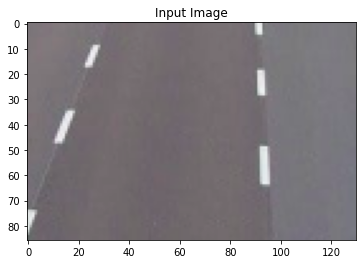

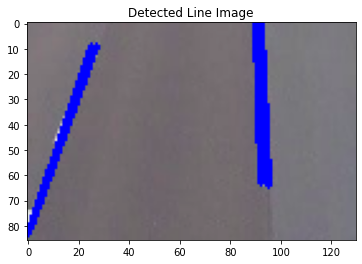

In [3]:
#Read image 
img = cv2.imread('line.png', cv2.IMREAD_COLOR)

# Visualize the input image
plt.imshow(img)
plt.title('Input Image')
plt.show()

#### YOUR CODE STARTS HERE #####
#convert the image to gray-scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#### YOUR CODE ENDS HERE #####

#Find the edges in the image using canny detector

edges = cv2.Canny(gray, 50, 200)

#### YOUR CODE STARTS HERE #####

lines = cv2.HoughLinesP(edges,
                        rho=1,
                        theta=np.pi/180,
                        threshold=15,
                        minLineLength=60,
                        maxLineGap=250)

# print(lines)

for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)

#### YOUR CODE ENDS HERE #####
plt.imshow(img)
plt.title('Detected Line Image')
plt.show()

##Question 2: Point matching using RANSAC

Given two sets of points related by affine transformation(with an outlier rate), use the RANSAC method to estimate the Affine transformation parameters between them and the number of inliers(Matching points).

What is the estimated number of inliers for an outlier rate of 0.9?


In [4]:
import numpy as np
np.random.seed(0)


# Affine Transformation
# |x'|  = |a, b| * |x|  +  |tx|
# |y'|    |c, d|   |y|     |ty|
# points_t =    A   * points_s  + t

# -------------------------------------------------------------

class Transform():

    def create_case(self, out_rate):
        ''' CREATE_CASE

            Method to generate a test case for affine transformation

            Input arguments:
            - out_rate : the percentage of outliers in test case

            Outputs:
            - points_s : Source points that will be transformed
            - points_t : warped points
            - A, t : parameters of affine transformation, A is a 2x2
            matrix, t is a 2x1 vector, both of them are created randomly

        '''


        # Generate an affine transformation
        # A is a 2x2 matrix, with values in range -2 to 2
        A = 4 * np.random.rand(2, 2) - 2

        # t is a 2x1 vector, with values in range -10 to 10
        t = 20 * np.random.rand(2, 1) - 10

        # Set the num_points = 1000 for the test case
        num_points = 1000

        #### YOUR CODE STARTS HERE ####
        # Compute the no. of outliers and the no. of inliers respectively
        outliers = int(out_rate * num_points)
        inliers = num_points - outliers
        #### YOUR CODE ENDS HERE ####

        # Gernerate source points, with scope from (0,0) to (100, 100)
        points_s = 100 * np.random.rand(2, num_points)

        # Initialization of the warped points matrix
        points_t = np.zeros((2, num_points))

        #### YOUR CODE STARTS HERE ####
        # Compute inliers in warped points matrix by applying A and t
        points_t[:, :inliers] = A @ points_s[:, :inliers]  + t
        #### YOUR CODE ENDS HERE ####

        # Outliers in warped points matrix
        points_t[:, inliers:] = 100 * np.random.rand(2, outliers)

        # Reset the order of warped points matrix
        # outliers and inliers will scatter randomly in test case
        rand_inx = np.random.permutation(num_points)
        points_s = points_s[:, rand_inx]
        points_t = points_t[:, rand_inx]

        return A, t, points_s, points_t

    def affine_transformation(self, points_s, points_t):  
        ''' AFFINE_TRANSFORMATION

            Perform affine transformation

            Input arguments:
            - points_t : points in target image
            - points_s : points in source image

            Outputs:

            - A, t : the affine transformation, A is a 2x2 matrix
            that indicates the rotation and scaling transformation,
            t is a 2x1 vector determines the translation

            Method:

            To estimate an affine transformation between two images,
            at least 3 corresponding points are needed.
            In this case, 6-parameter affine transformation are taken into
            consideration, which is shown as follows:

            | x' | = | a b | * | x | + | tx |
            | y' |   | c d |   | y |   | ty |

            For 3 corresponding points, 6 equations can be formed as below:

            | x1 y1 0  0  1 0 |       | a  |       | x1' |
            | 0  0  x1 y1 0 1 |       | b  |       | y1' |
            | x2 y2 0  0  1 0 |   *   | c  |   =   | x2' |
            | 0  0  x2 y2 0 1 |       | d  |       | y2' |
            | x3 y3 0  0  1 0 |       | tx |       | x3' |
            | 0  0  x3 y3 0 1 |       | ty |       | y3' |

            |------> M <------|   |-> theta <-|   |-> b <-|

            Solve the equation by calculating:  theta = M \ b
            Thus, affine transformation can be obtained as:

            A = | a b |     t = | tx |
                | c d |         | ty |

        '''

        #### YOUR CODE STARTS HERE ####

        M = np.stack([np.array([[x, y, 0, 0, 1, 0],
                                [0, 0, x, y, 0, 1]]) 
                      for x, y in points_s.T[0]]).reshape(-1,6)
        b = points_t.T.reshape(-1,1)
        ans = np.linalg.pinv(M) @ b
        ans = ans.reshape(3,2)
        return ans[:-1], ans[-1:].T

        #### YOUR CODE ENDS HERE ####
# -------------------------------------------------------------

# Create instance
tf = Transform()

# Generate a test case as validation with
# a rate of outliers
out_rate = 0.90
A_true, t_true, points_s, points_t = tf.create_case(out_rate)

# At least 3 corresponding points to
# estimate affine transformation
L = 3
# Randomly select 3 pairs of points to do estimation
idx = np.random.randint(0, points_s.shape[1], (L, 1))

A_test, t_test = tf.affine_transformation(points_s[:, idx], points_t[:, idx])

# -------------------------------------------------------------
# Test Class RansacClass
# The number of iterations in RANSAC
ITER_NUM = 2000


class RansacClass():

    def __init__(self, L=3, thr=1): 
        ''' __INIT__

            Initialize the instance.

            Input arguments:

            - L : the number of corresponding points,
            default is 3
            - thr : threshold that determines which points are inliers
            by comparing residual with it

        '''

        self.L = L
        self.thr = thr

    def calculate_distance(self, A, t, points_s, points_t):     
        ''' CALCULATE_DISTANCE

            Compute residual length between estimation and 
            real target points.
 

            Input arguments:

            - A, t : the estimated affine transformation
                     (using least square)
            - points_s : key points taken from source image
            - points_t : key points taken from target image

            Output:

            - residual : Euclidean distance between target 
            points and estimated points. Euclidean distance is
            nothing but the residual length

        '''

        ###YOUR CODE START HERE

        return np.linalg.norm(A @ points_s + t - points_t, axis=0)

        ###YOUR CODE ENDS HERE

    def apply_ransac(self, points_s, points_t):
        ''' APPLY_RANSAC

            Use this method to get the estimated affine 
            transformation, also inliers.

            Input arguments:

            - points_s : key points from source image
            - points_t : key points from target image

            Output:

            - A, t : estimated affine transformation
            - inliers : indices of inliers 

        '''
        #### YOUR CODE START HERE
        A, t = None, None
        count = 0
        for _ in range(ITER_NUM):
            idx = np.random.randint(0, points_s.shape[1], (self.L, 1))
            A_test, t_test = tf.affine_transformation(points_s[:, idx], points_t[:,idx])
            residual = self.calculate_distance(A_test, t_test, points_s, points_t)
            curr = np.sum(residual < self.thr)
            if curr > count:
                count = curr
                A, t = A_test, t_test

        residual = self.calculate_distance(A, t, points_s, points_t)
        return A, t, np.argwhere(residual < self.thr).T
        
        #### YOUR CODE ENDS HERE
# -------------------------------------------------------------

# Create instance
rs = RansacClass(L=3, thr=1)
residual = rs.calculate_distance(A_test, t_test, points_s, points_t)
A_rsc, t_rsc, inliers = rs.apply_ransac(points_s, points_t)
# print the number of inliners or point matches
print(inliers[0].shape)


(101,)


### Question 3: Detect corners in a given image using Harris Corner Detection Algorithm

Find the number of detected corner points in a given image (line.png) using Harris Corner Detection Algorithm. Note that, Following criterion MUST be satisfied while applying Harris Corner detection Algorithm:

(a)  The size of neighbourhood considered for corner detection = 2.
(b)  Aperture parameter of Sobel derivative used = 3.
(c)  Harris detector free parameter in the equation = 0.04.

How many corners are detected?



No. of corner points detected =  222


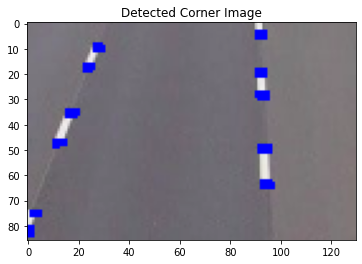

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

%matplotlib inline

# Read in the image
image = cv2.imread('line.png')

# Make a copy of the image
image_copy = np.copy(image)

# Change color to RGB (from BGR)
image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)

###YOUR CODE STARTS HERE

## STEP 1:  Convert to grayscale
gray = cv2.cvtColor(image_copy, cv2.COLOR_RGB2GRAY)

## STEP 2: Detect corners
dst = cv2.cornerHarris(gray,
                       blockSize=2,
                       ksize=3,
                       k=0.04)

## STEP 3: Dilate corner image to enhance corner points
dst = cv2.dilate(dst, None)

## STEP 4:set threshold value as 0.1 * (maximum value of dilated corner image obtained from STEP3)
corners = dst > (0.1 * dst.max())
image_copy[corners] = [0, 0, 255]

## STEP 5: Count numer of detected corner points and draw them on the image
print('No. of corner points detected = ', np.sum(corners))
plt.imshow(image_copy)
plt.title('Detected Corner Image')
plt.show()

### YOUR CODE ENDS HERE

# Part-2

In this section, we will train a neural network to learn to identify numerals from [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. Fill out the missing pieces in each of the following cells. 

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import timeit
import unittest

## Please DONOT remove these lines. 
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

### Data Loading and Pre-processing

In [7]:
# check availability of GPU and set the device accordingly
#### YOUR CODE STARTS HERE ####
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# define a transforms for preparing the dataset
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.1307), (0.3081))])
         # convert the image to a pytorch tensor
        # normalise the images with mean (0.1307) and std (0.3081) of the dataset
#### YOUR CODE ENDS HERE ####

In [8]:
# Load the MNIST training, test datasets using `torchvision.datasets.MNIST` using the transform defined above
#### YOUR CODE STARTS HERE ####
train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, download=True, transform=transform)
#### YOUR CODE ENDS HERE ####

In [9]:
# create dataloaders for training and test datasets
# use a batch size of 32 and set shuffle=True for the training set
#### YOUR CODE STARTS HERE ####
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32,
                                               shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32)
#### YOUR CODE ENDS HERE ####

### Network Definition

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32, 64, 3, 1)
        # define a max pooling layer with kernel size 2
        self.pool = nn.MaxPool2d(2)        
        # define dropout layer with a probability of 0.25
        self.drop1 = nn.Dropout2d(p=0.25)
        # define dropout layer with a probability of 0.5
        self.drop2 = nn.Dropout(p=0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(7744, 128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128, 10)
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Use the layers defined above in a sequential way (follow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you use the final FC layer
        #### YOUR CODE STARTS HERE ####
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = self.pool(out).reshape(out.shape[0], -1)
        out = self.drop1(out)
        out = F.relu(self.fc1(out))
        out = self.drop2(out)
        out = self.fc2(out)
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output

### Sanity Check
Make sure all the tests below pass without any errors, before you proceed with the training part.

In [11]:
import unittest

class TestImplementations(unittest.TestCase):
    
    # Dataloading tests
    def test_dataset(self):
        self.dataset_classes = ['0 - zero',
                                '1 - one',
                                '2 - two',
                                '3 - three',
                                '4 - four',
                                '5 - five',
                                '6 - six',
                                '7 - seven',
                                '8 - eight',
                                '9 - nine']
        self.assertTrue(train_dataset.classes == self.dataset_classes)
        self.assertTrue(train_dataset.train == True)
    
    def test_dataloader(self):        
        self.assertTrue(train_dataloader.batch_size == 32)
        self.assertTrue(test_dataloader.batch_size == 32)      
         
    def test_total_parameters(self):
        model = Net().to(device)
        self.assertTrue(sum(p.numel() for p in model.parameters()) == 1015946)

suite = unittest.TestLoader().loadTestsFromModule(TestImplementations())
unittest.TextTestRunner().run(suite)

...
----------------------------------------------------------------------
Ran 3 tests in 2.023s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

### Training and Inference

In [12]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
      #### YOUR CODE STARTS HERE ####
        # send the image, target to the device
        image, target = data.to(device), target.to(device)
        # flush out the gradients stored in optimizer
        optimizer.zero_grad()
        # pass the image to the model and assign the output to variable named output
        output = model(image)
        # calculate the loss (use nll_loss in pytorch)
        loss = F.nll_loss(output, target)
        # do a backward pass
        loss.backward()
        # update the weights
        optimizer.step()
      #### YOUR CODE ENDS HERE ####
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [13]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
          ### YOUR CODE STARTS HERE ####
            # send the image, target to the device
            image, target = data.to(device), target.to(device)
            # pass the image to the model and assign the output to variable named output
            output = model(image)    
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1]
          #### YOUR CODE ENDS HERE ####
            # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### Question 4

Use Adam as the optimiser and train the model for 25 epochs. Report the train, test loss and accuracies along with the total time taken for training. (Use plots if required)

Ans:

Train Epoch: 25 Loss: 0.000549, Accuracy: 59520/60000 (99%)

Test set: Average loss: 0.0288, Accuracy: 9925/10000 (99%)

Time Taken: 5 mins(Approx)

In [14]:
model = Net().to(device)
adam_optimizer = optim.Adam(model.parameters())
epochs = 25
test(model, device, test_dataloader)

for epoch in range(epochs):
    train(model, device, train_dataloader, adam_optimizer, epoch)
    test(model, device, test_dataloader)


Test set: Average loss: 2.3046, Accuracy: 980/10000 (10%)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.304116
Train Epoch: 0 [640/60000 (1%)]	Loss: 1.062977
Train Epoch: 0 [1280/60000 (2%)]	Loss: 0.973300
Train Epoch: 0 [1920/60000 (3%)]	Loss: 0.786895
Train Epoch: 0 [2560/60000 (4%)]	Loss: 0.288298
Train Epoch: 0 [3200/60000 (5%)]	Loss: 0.492492
Train Epoch: 0 [3840/60000 (6%)]	Loss: 0.255024
Train Epoch: 0 [4480/60000 (7%)]	Loss: 0.539823
Train Epoch: 0 [5120/60000 (9%)]	Loss: 0.364788
Train Epoch: 0 [5760/60000 (10%)]	Loss: 0.091347
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.169263
Train Epoch: 0 [7040/60000 (12%)]	Loss: 0.548135
Train Epoch: 0 [7680/60000 (13%)]	Loss: 0.435683
Train Epoch: 0 [8320/60000 (14%)]	Loss: 0.283340
Train Epoch: 0 [8960/60000 (15%)]	Loss: 0.043068
Train Epoch: 0 [9600/60000 (16%)]	Loss: 0.133765
Train Epoch: 0 [10240/60000 (17%)]	Loss: 0.102040
Train Epoch: 0 [10880/60000 (18%)]	Loss: 0.262423
Train Epoch: 0 [11520/60000 (19%)]	Loss: 0.191651
Train Epoch: 0 [121

### Question 5

Modify the network defined in the previous step to replace ReLU activations with Sigmoid and report the final test accuracy. Is there a drop in accuracy, what do you think is the reason? 

Ans:

**ReLU:**

Train Epoch: 25 Loss: 0.000549, Accuracy: 59520/60000 (99%)

Test set: Average loss: 0.0288, Accuracy: 9925/10000 (99%)

**Sigmoid:**

Train Epoch: 25	Loss: 0.000155, Accuracy: 59520/60000 (99%)

Test set: Average loss: 0.0320, Accuracy: 9909/10000 (99%)

Yes, there is slight drop in accuracy because sigmoid suffers from the vanishing gradient problem. Vanishing gradients lead to very small changes in the weights proportional to the partial derivative of the error function. Therefore, the deeper the network, the more the effect of vanishing gradients. This makes learning per iteration slower.

So, ReLU performs slightly better than sigmoid activations function.


In [22]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32, 64, 3, 1)
        # define a max pooling layer with kernel size 2
        self.pool = nn.MaxPool2d(2)        
        # define dropout layer with a probability of 0.25
        self.drop1 = nn.Dropout2d(p=0.25)
        # define dropout layer with a probability of 0.5
        self.drop2 = nn.Dropout(p=0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(7744, 128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128, 10)
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Use the layers defined above in a sequential way (follow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a sigmod activation. 
        # use the first dropout after maxpool and the other one before you use the final FC layer
        #### YOUR CODE STARTS HERE ####
        out = torch.sigmoid(self.conv1(x))
        out = torch.sigmoid(self.conv2(out))
        out = torch.sigmoid(self.conv3(out))
        out = self.pool(out).reshape(out.shape[0], -1)
        out = self.drop1(out)
        out = torch.sigmoid(self.fc1(out))
        out = self.drop2(out)
        out = self.fc2(out)
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output

In [23]:
model1 = Net1().to(device)
adam_optimizer = optim.Adam(model1.parameters())
for epoch in range(epochs):
    train(model1, device, train_dataloader, adam_optimizer, epoch)
    test(model1, device, test_dataloader)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.579631
Train Epoch: 0 [640/60000 (1%)]	Loss: 2.528513
Train Epoch: 0 [1280/60000 (2%)]	Loss: 2.392618
Train Epoch: 0 [1920/60000 (3%)]	Loss: 2.323788
Train Epoch: 0 [2560/60000 (4%)]	Loss: 2.309338
Train Epoch: 0 [3200/60000 (5%)]	Loss: 2.363065
Train Epoch: 0 [3840/60000 (6%)]	Loss: 2.362892
Train Epoch: 0 [4480/60000 (7%)]	Loss: 2.361253
Train Epoch: 0 [5120/60000 (9%)]	Loss: 2.334592
Train Epoch: 0 [5760/60000 (10%)]	Loss: 2.395062
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.231127
Train Epoch: 0 [7040/60000 (12%)]	Loss: 2.151688
Train Epoch: 0 [7680/60000 (13%)]	Loss: 1.805056
Train Epoch: 0 [8320/60000 (14%)]	Loss: 1.490790
Train Epoch: 0 [8960/60000 (15%)]	Loss: 1.235349
Train Epoch: 0 [9600/60000 (16%)]	Loss: 1.077798
Train Epoch: 0 [10240/60000 (17%)]	Loss: 1.142018
Train Epoch: 0 [10880/60000 (18%)]	Loss: 1.140368
Train Epoch: 0 [11520/60000 (19%)]	Loss: 0.794944
Train Epoch: 0 [12160/60000 (20%)]	Loss: 1.039845
Train Epoch: 0 [12800/60000 (

### Question 6

Train the network defined in Question-1 with a different optimiser other than Adam, do you see any difference in performance? Substantiate your observations with relevant explanations.

Ans:

Train Epoch: 25	Loss: 0.001549, Accuracy: 59520/60000 (99%)

Test set: Average loss: 0.0309, Accuracy: 9915/10000 (99%)

Adam optimizer performs better than SGD because it combines advantages of two SGD extensions
- Root Mean Square Propagation (RMSProp)
- Adaptive Gradient Algorithm (AdaGrad)

It also computes individual adaptive learning rates for different parameters. Hence Adam performs better than SGD.

In [18]:
model2 = Net().to(device)
sgd_optimizer = optim.SGD(model2.parameters(), lr=0.01)
for epoch in range(epochs):
    train(model2, device, train_dataloader, sgd_optimizer, epoch)
    test(model2, device, test_dataloader)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.314092
Train Epoch: 0 [640/60000 (1%)]	Loss: 2.286352
Train Epoch: 0 [1280/60000 (2%)]	Loss: 2.244347
Train Epoch: 0 [1920/60000 (3%)]	Loss: 2.223311
Train Epoch: 0 [2560/60000 (4%)]	Loss: 2.108648
Train Epoch: 0 [3200/60000 (5%)]	Loss: 1.885683
Train Epoch: 0 [3840/60000 (6%)]	Loss: 1.181045
Train Epoch: 0 [4480/60000 (7%)]	Loss: 1.110717
Train Epoch: 0 [5120/60000 (9%)]	Loss: 0.636558
Train Epoch: 0 [5760/60000 (10%)]	Loss: 0.634376
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.865545
Train Epoch: 0 [7040/60000 (12%)]	Loss: 1.591638
Train Epoch: 0 [7680/60000 (13%)]	Loss: 0.400422
Train Epoch: 0 [8320/60000 (14%)]	Loss: 0.717608
Train Epoch: 0 [8960/60000 (15%)]	Loss: 0.793933
Train Epoch: 0 [9600/60000 (16%)]	Loss: 0.805783
Train Epoch: 0 [10240/60000 (17%)]	Loss: 1.090636
Train Epoch: 0 [10880/60000 (18%)]	Loss: 1.067433
Train Epoch: 0 [11520/60000 (19%)]	Loss: 0.691438
Train Epoch: 0 [12160/60000 (20%)]	Loss: 0.243617
Train Epoch: 0 [12800/60000 (

### Question 7

Initialize the `Conv2d` layers in the network defined in Question-1 `(Net)` with all ones (both weights and bias). Train the network with Adam optimizer and report the final test accuracy. Is there any difference in the performance? If yes, what do you think is the reason?

Ans:

Train Epoch: 25	Loss: 2.279479, Accuracy: 59520/60000 (99%)

Test set: Average loss: 2.3011, Accuracy: 1135/10000 (11%)

If all weights start with equal values than the model will never learn because the backpropagated error is proportion to the values of the weights.

Hence the model prediction is as good as a random guess, i.e, the model has an accuracy nearly equal to 10%

In [19]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32, 64, 3, 1)
        # define a max pooling layer with kernel size 2
        self.pool = nn.MaxPool2d(2)        
        # define dropout layer with a probability of 0.25
        self.drop1 = nn.Dropout2d(p=0.25)
        # define dropout layer with a probability of 0.5
        self.drop2 = nn.Dropout(p=0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(7744, 128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128, 10)
        for layer in {self.conv1, self.conv2, self.conv3}:
            nn.init.ones_(layer.weight)
            nn.init.ones_(layer.bias)
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Use the layers defined above in a sequential way (follow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you use the final FC layer
        #### YOUR CODE STARTS HERE ####
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = self.pool(out).reshape(out.shape[0], -1)
        out = self.drop1(out)
        out = F.relu(self.fc1(out))
        out = self.drop2(out)
        out = self.fc2(out)
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output

model3 = Net2().to(device)
adam_optimizer = optim.Adam(model3.parameters())
for epoch in range(epochs):
    train(model3, device, train_dataloader, adam_optimizer, epoch)
    test(model3, device, test_dataloader)

Train Epoch: 0 [0/60000 (0%)]	Loss: 243359.718750
Train Epoch: 0 [640/60000 (1%)]	Loss: 2.312099
Train Epoch: 0 [1280/60000 (2%)]	Loss: 2.233172
Train Epoch: 0 [1920/60000 (3%)]	Loss: 2.166821
Train Epoch: 0 [2560/60000 (4%)]	Loss: 2.309107
Train Epoch: 0 [3200/60000 (5%)]	Loss: 2.307088
Train Epoch: 0 [3840/60000 (6%)]	Loss: 2.309239
Train Epoch: 0 [4480/60000 (7%)]	Loss: 2.310329
Train Epoch: 0 [5120/60000 (9%)]	Loss: 2.230056
Train Epoch: 0 [5760/60000 (10%)]	Loss: 2.155207
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.164468
Train Epoch: 0 [7040/60000 (12%)]	Loss: 2.232571
Train Epoch: 0 [7680/60000 (13%)]	Loss: 2.296316
Train Epoch: 0 [8320/60000 (14%)]	Loss: 2.228609
Train Epoch: 0 [8960/60000 (15%)]	Loss: 2.303649
Train Epoch: 0 [9600/60000 (16%)]	Loss: 2.231937
Train Epoch: 0 [10240/60000 (17%)]	Loss: 2.301775
Train Epoch: 0 [10880/60000 (18%)]	Loss: 2.308763
Train Epoch: 0 [11520/60000 (19%)]	Loss: 2.298506
Train Epoch: 0 [12160/60000 (20%)]	Loss: 2.149262
Train Epoch: 0 [12800/60

### Question 8

Initialize the network defined in Question-1 `(Net)` with Xavier's initialization ([torch.nn.init.xavier_normal](https://pytorch.org/docs/stable/nn.init.html))(for bias use zero). Train the network with Adam optimizer and report the final test accuracy.

Ans:

Train Epoch: 25 Loss: 0.000751, Accuracy: 59520/60000 (99%)

Test set: Average loss: 0.0268, Accuracy: 9945/10000 (99%)

In [20]:
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32, 64, 3, 1)
        # define a max pooling layer with kernel size 2
        self.pool = nn.MaxPool2d(2)        
        # define dropout layer with a probability of 0.25
        self.drop1 = nn.Dropout2d(p=0.25)
        # define dropout layer with a probability of 0.5
        self.drop2 = nn.Dropout(p=0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(7744, 128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128, 10)
        for layer in {self.conv1, self.conv2, self.conv3}:
            nn.init.xavier_normal_(layer.weight)
            nn.init.zeros_(layer.bias)
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Use the layers defined above in a sequential way (follow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you use the final FC layer
        #### YOUR CODE STARTS HERE ####
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = self.pool(out).reshape(out.shape[0], -1)
        out = self.drop1(out)
        out = F.relu(self.fc1(out))
        out = self.drop2(out)
        out = self.fc2(out)
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output

model4 = Net3().to(device)
adam_optimizer = optim.Adam(model4.parameters())
for epoch in range(epochs):
    train(model4, device, train_dataloader, adam_optimizer, epoch)
    test(model4, device, test_dataloader)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.297005
Train Epoch: 0 [640/60000 (1%)]	Loss: 0.850418
Train Epoch: 0 [1280/60000 (2%)]	Loss: 0.662640
Train Epoch: 0 [1920/60000 (3%)]	Loss: 0.554539
Train Epoch: 0 [2560/60000 (4%)]	Loss: 0.544767
Train Epoch: 0 [3200/60000 (5%)]	Loss: 0.395785
Train Epoch: 0 [3840/60000 (6%)]	Loss: 0.317112
Train Epoch: 0 [4480/60000 (7%)]	Loss: 0.300269
Train Epoch: 0 [5120/60000 (9%)]	Loss: 0.109791
Train Epoch: 0 [5760/60000 (10%)]	Loss: 0.385626
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.220525
Train Epoch: 0 [7040/60000 (12%)]	Loss: 0.315603
Train Epoch: 0 [7680/60000 (13%)]	Loss: 0.032788
Train Epoch: 0 [8320/60000 (14%)]	Loss: 0.208895
Train Epoch: 0 [8960/60000 (15%)]	Loss: 0.203004
Train Epoch: 0 [9600/60000 (16%)]	Loss: 0.261917
Train Epoch: 0 [10240/60000 (17%)]	Loss: 0.063229
Train Epoch: 0 [10880/60000 (18%)]	Loss: 0.220098
Train Epoch: 0 [11520/60000 (19%)]	Loss: 0.066943
Train Epoch: 0 [12160/60000 (20%)]	Loss: 0.033419
Train Epoch: 0 [12800/60000 (

### Question 9

Add three batch-norm layers to the network defined in `Question-1` and report the final test accuracy. How does batch-norm help?

Ans:

Train Epoch: 25	Loss: 0.071447, Accuracy: 59520/60000 (99%)

Test set: Average loss: 0.0319, Accuracy: 9928/10000 (99%)

Batch-norm slightly increases the accuracy because it has a stabilizing effect on the learning process.
It also helps in reducing the number of training epochs required to train the network.

In [21]:
class Net4(nn.Module):
    def __init__(self):
        super(Net4, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.bn1 = nn.BatchNorm2d(16)
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.bn2 = nn.BatchNorm2d(32)
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32, 64, 3, 1)
        self.bn3 = nn.BatchNorm2d(64)
        # define a max pooling layer with kernel size 2
        self.pool = nn.MaxPool2d(2)        
        # define dropout layer with a probability of 0.25
        self.drop1 = nn.Dropout2d(p=0.25)
        # define dropout layer with a probability of 0.5
        self.drop2 = nn.Dropout(p=0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(7744, 128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128, 10)
        for layer in {self.conv1, self.conv2, self.conv3}:
            nn.init.xavier_normal_(layer.weight)
            nn.init.zeros_(layer.bias)
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Use the layers defined above in a sequential way (follow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you use the final FC layer
        #### YOUR CODE STARTS HERE ####
        out = self.bn1(F.relu(self.conv1(x)))
        out = self.bn2(F.relu(self.conv2(out)))
        out = self.bn3(F.relu(self.conv3(out)))
        
        out = self.pool(out).reshape(out.shape[0], -1)
        out = self.drop1(out)
        out = F.relu(self.fc1(out))
        out = self.drop2(out)
        out = self.fc2(out)
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output

model5 = Net4().to(device)
adam_optimizer = optim.Adam(model5.parameters())
for epoch in range(epochs):
    train(model5, device, train_dataloader, adam_optimizer, epoch)
    test(model5, device, test_dataloader)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.461955
Train Epoch: 0 [640/60000 (1%)]	Loss: 0.911555
Train Epoch: 0 [1280/60000 (2%)]	Loss: 0.501930
Train Epoch: 0 [1920/60000 (3%)]	Loss: 0.308567
Train Epoch: 0 [2560/60000 (4%)]	Loss: 0.888708
Train Epoch: 0 [3200/60000 (5%)]	Loss: 0.498751
Train Epoch: 0 [3840/60000 (6%)]	Loss: 0.203114
Train Epoch: 0 [4480/60000 (7%)]	Loss: 0.218973
Train Epoch: 0 [5120/60000 (9%)]	Loss: 0.347611
Train Epoch: 0 [5760/60000 (10%)]	Loss: 0.558437
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.403482
Train Epoch: 0 [7040/60000 (12%)]	Loss: 0.525348
Train Epoch: 0 [7680/60000 (13%)]	Loss: 0.106432
Train Epoch: 0 [8320/60000 (14%)]	Loss: 0.301752
Train Epoch: 0 [8960/60000 (15%)]	Loss: 0.222171
Train Epoch: 0 [9600/60000 (16%)]	Loss: 0.300001
Train Epoch: 0 [10240/60000 (17%)]	Loss: 0.074021
Train Epoch: 0 [10880/60000 (18%)]	Loss: 0.427606
Train Epoch: 0 [11520/60000 (19%)]	Loss: 0.265355
Train Epoch: 0 [12160/60000 (20%)]	Loss: 0.342379
Train Epoch: 0 [12800/60000 (

# Part-3 (Optional)

This section is un-graded and purely for practice. 

Main focus of this part is to help you flex the deep learning muscles built in the above part. You should build a network on the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This dataset is similar to MNIST but unlike MNIST, the images are colored and more complex. 

As of writing this, the state-of-the-art(SoTA) performance on this dataset is 98.98%. You can try to start with the simple network we defined above for the MNSIT dataset(with some modification for dealing with different sized colored images unlike MNIST). But to achive the SoTA performance you need to do a lot of hackery. These are list of few things, we would encourage you to try: 

- Use data augmentation wisely. Read and understand how to perform the augmentations listed below. 
    * RandomFlips, Color Jittering
    * Cutout, Cutmix
    * Mixup
    * Auto-augment

- Try to increase the image size using standard image interpolation techniques. Try using tricks like Progressive resizing of images and see if it helps. 

- After certain number of layers, adding more layer might not be of much help, run experiments on SVHN and see if you observe this. 

- To understand the difficulties in training deeper networks read this paper: [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)

- To improve the performance on SVHN, try using architectures like [ResNet](https://arxiv.org/abs/1512.03385), [DesnseNet](https://arxiv.org/abs/1608.06993) or [EfficientNet](https://arxiv.org/abs/1905.11946). Most of these architectures are available by default in PyTorch.
